In [4]:
"""
reference:
    https://engl.is/causal-analysis-introduction-examples-in-python-and-pymc.html 
    https://github.com/log0ymxm/causal-inference-notes/blob/master/Causal%20Inference%20on%20the%20Lalonde%20Dataset.ipynb 

"""

'\nreference:\n    https://engl.is/causal-analysis-introduction-examples-in-python-and-pymc.html \n    https://github.com/log0ymxm/causal-inference-notes/blob/master/Causal%20Inference%20on%20the%20Lalonde%20Dataset.ipynb \n\n'

In [5]:
#!pip install causalinference

    100% |████████████████████████████████| 61kB 2.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for causalinference ... - \ | done
  Stored in directory: /Users/riow/Library/Caches/pip/wheels/31/3b/84/6b475799114c4c8cbaa401aff4e9fe088fc12acf55c83c1d2a
Successfully built causalinference
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from patsy import dmatrices

import pymc3 as pm

from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

import statsmodels.api as sm
import statsmodels.formula.api as smf

from causalinference import CausalModel

# set some plotting aesthetics, similar to ggplot
sns.set(palette = "colorblind", font_scale = 1.35,
        rc = {"figure.figsize": (12,9), "axes.facecolor": ".92"})

/anaconda/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# NSW Data Files (Dehejia-Wahha Sample)
# http://users.nber.org/~rdehejia/data/nswdata2.html

cps = pd.read_csv('data/lalonde/cps_controls.txt', delimiter='  ', names=[
        'treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr',
        're74', 're75', 're78'
    ])

original_treatment = pd.read_csv('data/lalonde/nswre74_treated.txt', delimiter='  ', names=[
        'treat', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr',
        're74', 're75', 're78'        
    ])

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [3]:
cps.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78
0,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.670,25243.550,25564.670
1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.971,5852.565,13496.080
2,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.020,25130.760,25564.670
3,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.370,25243.550,25564.670
4,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295,10727.610,9860.869


In [4]:
original_treatment.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.7899


In [5]:
unmatched_raw = pd.concat([cps, original_treatment], axis=0)

unmatched_raw['u74'] = (unmatched_raw.re74 == 0).astype(np.int32)
unmatched_raw['u75'] = (unmatched_raw.re74 == 0).astype(np.int32)

unmatched_raw[['re74_div', 're75_div', 're78_div']] = unmatched_raw[['re74', 're75', 're78']] / 1000
unmatched_raw.shape

(10260, 15)

In [6]:
unmatched_raw.head()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,re74_div,re75_div,re78_div
0,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.670,25243.550,25564.670,0,0,21.516670,25.243550,25.564670
1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.971,5852.565,13496.080,0,0,3.175971,5.852565,13.496080
2,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.020,25130.760,25564.670,0,0,23.039020,25.130760,25.564670
3,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.370,25243.550,25564.670,0,0,24.994370,25.243550,25.564670
4,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295,10727.610,9860.869,0,0,1.669295,10.727610,9.860869


In [7]:
unmatched_raw.tail()

,treat,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,re74_div,re75_div,re78_div
180,1.0,33.0,12.0,1.0,0.0,1.0,0.0,20279.95,10941.35,15952.600,0,0,20.27995,10.94135,15.952600
181,1.0,25.0,14.0,1.0,0.0,1.0,0.0,35040.07,11536.57,36646.950,0,0,35.04007,11.53657,36.646950
182,1.0,35.0,9.0,1.0,0.0,1.0,1.0,13602.43,13830.64,12803.970,0,0,13.60243,13.83064,12.803970
183,1.0,35.0,8.0,1.0,0.0,1.0,1.0,13732.07,17976.15,3786.628,0,0,13.73207,17.97615,3.786628
184,1.0,33.0,11.0,1.0,0.0,1.0,1.0,14660.71,25142.24,4181.942,0,0,14.66071,25.14224,4.181942


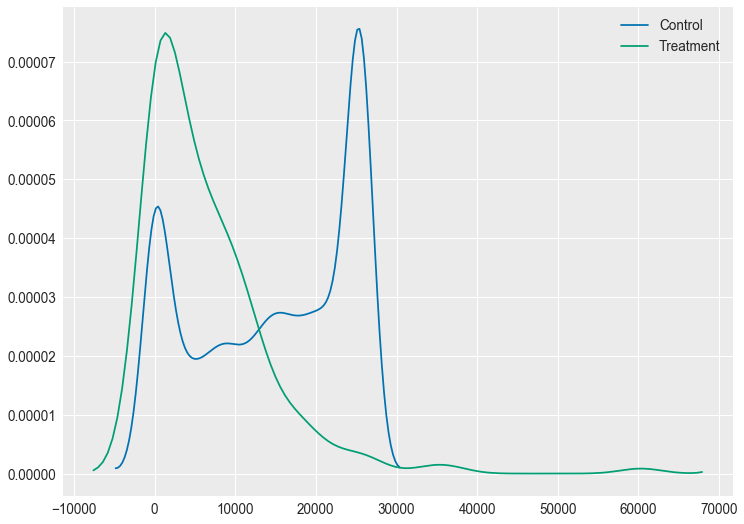

In [8]:
sns.kdeplot(unmatched_raw[unmatched_raw.treat == 0].re78, label='Control')
sns.kdeplot(unmatched_raw[unmatched_raw.treat == 1].re78, label='Treatment');

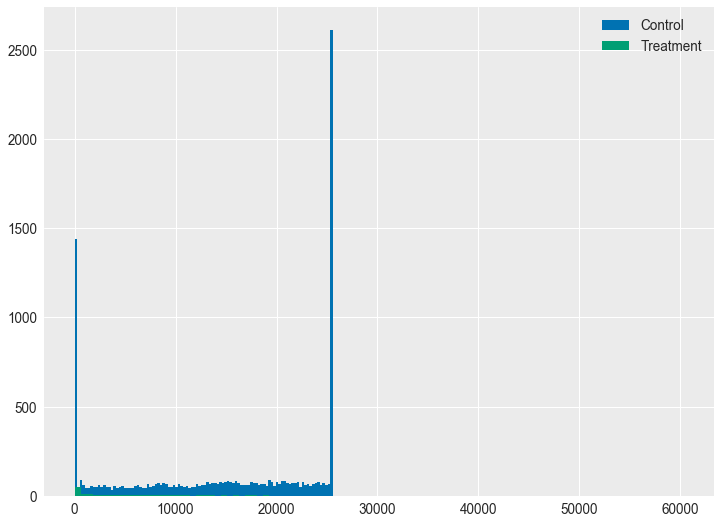

In [9]:
plt.hist(unmatched_raw[unmatched_raw.treat == 0].re78.dropna(), label='Control', bins=100)
plt.hist(unmatched_raw[unmatched_raw.treat == 1].re78.dropna(), label='Treatment', bins=100)
plt.legend();

# Using the causalinference library

In [10]:
cols = ['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 
        're74_div', 're75_div', 'u74', 'u75', 'treat', 're78_div']
unmatched_raw_cols = unmatched_raw[cols].dropna()

In [11]:
causal_model = CausalModel(
    X=unmatched_raw_cols[['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 
                          're74_div', 're75_div', 'u74', 'u75']].values,
    D=unmatched_raw_cols.treat.values,
    Y=unmatched_raw_cols.re78_div.values
)
causal_model.est_propensity()
causal_model.trim_s()
causal_model.stratify_s()
causal_model.est_via_ols()
causal_model.est_via_matching(bias_adj=True)
causal_model.est_via_weighting()
print(causal_model.summary_stats)
print(causal_model.estimates)
print(causal_model.propensity)
print(causal_model.strata)

LinAlgError: Singular matrix